In [1]:
# Importing necessary libraries
import os
import operator
import glob
import numpy as np
import cv2
import sys
from imutils import paths
from image_enhance import image_enhance
from sklearn.metrics import accuracy_score, precision_score, f1_score
from finger_utils import *
from finger_preprocessing import *
from plots import *
# pyeer library: pip install pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

In [2]:
# Initiate ORB detector for matching keypoints
MAX_FEATURES = 500
TRAIN_PER_CLASS = 6
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.25
DIST_THRESHOLD = 30

In [3]:
# reading files
base_dir = os.getcwd()
print(base_dir)
dataset_dir = os.path.join(base_dir, 'RawDataset')
img_files = glob.glob(dataset_dir + '\*.bmp')
print(img_files)
enhanced_dir = os.path.join(base_dir, 'enhanced')
if not os.path.exists(enhanced_dir):
    os.mkdir(enhanced_dir)
trainingPath = os.path.sep.join([enhanced_dir, "training"])
testingPath = os.path.sep.join([enhanced_dir, "testing"])
if not os.path.exists(trainingPath):
    os.mkdir(trainingPath)
if not os.path.exists(testingPath):
    os.mkdir(testingPath)

D:\Projects\FingerPrintAnalysis\Project
['D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_1.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_2.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_3.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_4.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_5.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_6.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_7.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\anu_8.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\arun_1.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\arun_2.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\arun_3.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\arun_4.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\arun_5.bmp', 'D:\\Projects\\FingerPrintAnalysis\\Project\\RawDataset\\

In [4]:
for image in img_files:
        img_name = image.split(os.path.sep)[-1]
        img = cv2.imread(image)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        rows,cols = img.shape
        aspect_ratio = np.double(rows)/np.double(cols)
        new_rows = 350; # randomly selected number
        new_cols = new_rows/aspect_ratio
        img = cv2.resize(img,(np.int(new_cols),np.int(new_rows)))
        enhanced_img = image_enhance(img)
        # cv2.normalize(enhanced_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=int)
        print('saving the image {}'.format(img_name))
        cv2.imwrite(os.path.join(enhanced_dir, img_name), (255*enhanced_img))

saving the image anu_1.bmp
saving the image anu_2.bmp
saving the image anu_3.bmp
saving the image anu_4.bmp
saving the image anu_5.bmp
saving the image anu_6.bmp
saving the image anu_7.bmp
saving the image anu_8.bmp
saving the image arun_1.bmp
saving the image arun_2.bmp
saving the image arun_3.bmp
saving the image arun_4.bmp
saving the image arun_5.bmp
saving the image arun_6.bmp
saving the image arun_7.bmp
saving the image arun_8.bmp


In [5]:
def get_image_label(filename):
    image = filename.split(os.path.sep)
    return image[len(image)-1]


def get_image_class(filename):
    return get_image_label(filename).split('_')[0]

# Splits the dataset on training and testing set
def split_dataset(data, test_size):
    train, test = train_test_split(data, test_size=test_size, random_state=42)
    return train, test

In [6]:
def prepare_dataset(file_names):
    '''
    Coversion to grayscale and enhancement. Split into training and test set.
    :param file_names: All fingerprint images as file names
    :return: train_set, test_set: 2 dictionaries for training and test,
             where the key is the name of the image and the value is the image itself
    '''
    train_set = {}
    test_set = {}
    data = []  # list of tuples
    temp_label = get_image_class(file_names[0])  # sets the image class (101)
    for filename in file_names:
        img = cv2.imread(filename)
        label = get_image_label(filename)
        print('Processing image {} ...  '.format(label))
        if temp_label != get_image_class(filename):
            train, test = split_dataset(data, 0.2)
            train_set.update(train)
            test_set.update(test)
            temp_label = get_image_class(filename)
            data = []
        data.append((label, img))

        if filename == file_names[len(file_names) - 1]:
            train, test = split_dataset(data, 0.2)
            train_set.update(train)
            test_set.update(test)

    print('DONE')
    return train_set, test_set

In [7]:
enhanced_img_list = glob.glob(enhanced_dir+"\*.bmp")
enhanced_img_list
train_set, test_set = prepare_dataset(enhanced_img_list)

Processing image anu_1.bmp ...  
Processing image anu_2.bmp ...  
Processing image anu_3.bmp ...  
Processing image anu_4.bmp ...  
Processing image anu_5.bmp ...  
Processing image anu_6.bmp ...  
Processing image anu_7.bmp ...  
Processing image anu_8.bmp ...  
Processing image arun_1.bmp ...  
Processing image arun_2.bmp ...  
Processing image arun_3.bmp ...  
Processing image arun_4.bmp ...  
Processing image arun_5.bmp ...  
Processing image arun_6.bmp ...  
Processing image arun_7.bmp ...  
Processing image arun_8.bmp ...  
DONE


In [8]:
print(train_set.keys())
print(test_set.keys())
print('Size of the training set:', len(train_set))
print('Size of the test set:', len(test_set))

dict_keys(['anu_1.bmp', 'anu_8.bmp', 'anu_3.bmp', 'anu_5.bmp', 'anu_4.bmp', 'anu_7.bmp', 'arun_1.bmp', 'arun_8.bmp', 'arun_3.bmp', 'arun_5.bmp', 'arun_4.bmp', 'arun_7.bmp'])
dict_keys(['anu_2.bmp', 'anu_6.bmp', 'arun_2.bmp', 'arun_6.bmp'])
Size of the training set: 12
Size of the test set: 4


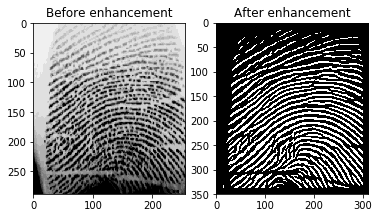

In [9]:
plt.subplot(1, 2, 1)
plt.title('Before enhancement')
img_fpr = cv2.imread(img_files[0])
plt.imshow(img_fpr, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After enhancement')
img_fer = cv2.imread(enhanced_img_list[0])
plt.imshow(img_fer, cmap='gray')
plt.show()

In [10]:
# Initiate ORB detector for matching keypoints
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [11]:
# Returns feature descripors for all images from the dataset
def get_feature_descriptors(dataset):
    feature_descriptors = {}
    for image_id, image in dataset.items():
        kp, des = orb.detectAndCompute(image, None)
        feature_descriptors[image_id] = des
    return feature_descriptors

In [12]:
# Returns best_matches between training features descriptors and query image
def get_best_matches(query_image, trained_features, distance_threshold):
    best_matches_dict = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) # features of the query image
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            best_matches_dict[train_image_id] = len(best_matches) # matching function = length of best mat ches to given threshold
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True) # sort by value - feature distance
    return best_matches_dict

In [13]:
# Apply homography to test and train image
# Homography or image alignment: to perfectly line up the features in two images
def apply_homography(query_image, closest_image):
    kp1, des1 = orb.detectAndCompute(query_image, None)
    kp2, des2 = orb.detectAndCompute(closest_image, None)
    matches = bf.match(des1, des2)
    # Apply homography
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    # M matrix that represents the homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    # Use homography
    height, width = query_image.shape[:2]
    # The function warpPerspective transforms the source image using the specified matrix
    im1Reg = cv2.warpPerspective(closest_image, M, (width, height))
    # Plot aligned query and train image
    plt.subplot(1, 2, 1)
    plt.imshow(im1Reg, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(query_image, cmap='gray')
    plt.show()

In [14]:
from collections import defaultdict
def classify_fpr(best_matches_dict, rank):
    '''
    Counts how many fprs from the same class are there in the first ranked
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param rank: To take the first ranked closest features
    :return first_rank_sorted: dictionary, where key denotes the fpr class and
    the value is how many times it appears in the first ranked fprs
    '''
    first_rank_fprs = defaultdict(int)
    for fpr_name, distance in best_matches_dict[0:rank]:
        fpr_class = get_image_class(fpr_name)
        first_rank_fprs[fpr_class] += 1
    first_rank_sorted = sorted(first_rank_fprs.items(), key = operator.itemgetter(1), reverse=True)
    return first_rank_sorted

In [15]:
def draw_keypoints_matches(fpr1, fpr2):
    kp1, des1 = orb.detectAndCompute(fpr1, None)
    kp2, des2 = orb.detectAndCompute(fpr2, None)
    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False)
    imMatches = cv2.drawMatches(fpr1, kp1, fpr2, kp2,matches[:10], None)
    plt.imshow(imMatches)
    plt.show()

## Identification Scenario

In [16]:
train_feature_descriptors = get_feature_descriptors(train_set)

In [17]:
# Definition of identification scenario
def perform_identification_scenario(dist_threshold, rank, should_draw):
    true_y = []
    pred_y = []
    total_prob = 0
    print("----- START, threshold = {}, rank = {} -----".format(dist_threshold, rank))
    for test_image_id, test_image in test_set.items():
        # Get the distances between the query image and all other training images
        best_matches_dict = get_best_matches(test_image, train_feature_descriptors, dist_threshold)
        true_class = get_image_class(test_image_id)
        # Classify the first closest features according to the given rank
        first_rank_fprs = classify_fpr(best_matches_dict, rank)
        predicted_class = first_rank_fprs[0][0]
        prob = first_rank_fprs[0][1] / TRAIN_PER_CLASS
        total_prob += prob
        true_y.append(true_class) # true_class
        pred_y.append(predicted_class)
        if should_draw: # Check whether to draw the homography and the matching keypoints
            closest_img_id = best_matches_dict[0][0]
            closest_img = train_set.get(closest_img_id)
            apply_homography(test_image, closest_img) # image alignment
            draw_keypoints_matches(test_image, closest_img)
            print('Query fingerprint ID: ' + test_image_id)
            print('Best matching fingerprint ID: ' + closest_img_id)
    avg_probability = total_prob/len(test_set)
    print("Averaged probability for rank %d and threshold %d is %f "%(rank, dist_threshold, avg_probability))
    print("Accuracy for rank %d and threshold %d is %f "%(rank, dist_threshold, accuracy_score(true_y, pred_y)))
    return avg_probability

In [18]:
rank = 3
for dist_threshold in range(20, 70, 10):
    perform_identification_scenario(dist_threshold, rank, False)

----- START, threshold = 20, rank = 3 -----
Averaged probability for rank 3 and threshold 20 is 0.416667 
Accuracy for rank 3 and threshold 20 is 0.500000 
----- START, threshold = 30, rank = 3 -----
Averaged probability for rank 3 and threshold 30 is 0.416667 
Accuracy for rank 3 and threshold 30 is 1.000000 
----- START, threshold = 40, rank = 3 -----
Averaged probability for rank 3 and threshold 40 is 0.500000 
Accuracy for rank 3 and threshold 40 is 1.000000 
----- START, threshold = 50, rank = 3 -----
Averaged probability for rank 3 and threshold 50 is 0.500000 
Accuracy for rank 3 and threshold 50 is 1.000000 
----- START, threshold = 60, rank = 3 -----
Averaged probability for rank 3 and threshold 60 is 0.500000 
Accuracy for rank 3 and threshold 60 is 1.000000 


In [19]:
dist_threshold = 50
avg_probabilities = []
rank_range = range(1, 10, 1)
for rank in rank_range:
    avg_probabilities.append(perform_identification_scenario(dist_threshold, rank, False))

----- START, threshold = 50, rank = 1 -----
Averaged probability for rank 1 and threshold 50 is 0.166667 
Accuracy for rank 1 and threshold 50 is 1.000000 
----- START, threshold = 50, rank = 2 -----
Averaged probability for rank 2 and threshold 50 is 0.333333 
Accuracy for rank 2 and threshold 50 is 1.000000 
----- START, threshold = 50, rank = 3 -----
Averaged probability for rank 3 and threshold 50 is 0.500000 
Accuracy for rank 3 and threshold 50 is 1.000000 
----- START, threshold = 50, rank = 4 -----
Averaged probability for rank 4 and threshold 50 is 0.666667 
Accuracy for rank 4 and threshold 50 is 1.000000 
----- START, threshold = 50, rank = 5 -----
Averaged probability for rank 5 and threshold 50 is 0.791667 
Accuracy for rank 5 and threshold 50 is 1.000000 
----- START, threshold = 50, rank = 6 -----
Averaged probability for rank 6 and threshold 50 is 0.916667 
Accuracy for rank 6 and threshold 50 is 1.000000 
----- START, threshold = 50, rank = 7 -----
Averaged probability

## CMC Curve

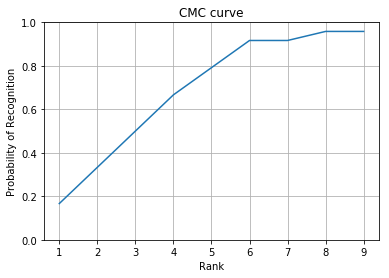

In [20]:
get_cmc_curve(rank_range, avg_probabilities)

In [21]:
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [22]:
print('Classes in the training set = {}'.format(authentication_databases.keys()))

Classes in the training set = dict_keys(['anu', 'arun'])


In [23]:
def count_same_fprs(feature_distances, len_best_matches):
    '''
    Counts how many fprs are close to the query fpr
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param len_best_matches: Predefined value for the length of best features
    :return count_same: number of same fprs paris within the given len_best_matches
    '''
    count_same = 0
    for features in feature_distances:
        if int(features[1]) > len_best_matches: # Compare the len of best features for the given feature with the predefined len
            count_same += 1
    return count_same

In [24]:
def perform_authentication_scenario(dist_threshold, len_best_matches):
    true_y = []
    pred_y = []
    total_distances = []
    print("----- START, Threshold = {} -----".format(dist_threshold))
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        for test_image_id, test_image in test_set.items():
            best_matches_dict = get_best_matches(test_image, authentication_db, dist_threshold)
            total_distances.append(best_matches_dict[0])
            count_same = count_same_fprs(best_matches_dict, len_best_matches)
            ratio = count_same/len(authentication_db.keys())
            test_image_class = get_image_class(test_image_id)
            true_class = 1 if test_image_class == authentication_db_key else 0
            true_y.append(true_class)
            if ratio >= 0.5:
                pred_y.append(1)
            else:
                pred_y.append(0)
    identical = true_y
    print("Accuracy is %f "%(round(accuracy_score(true_y, pred_y),4)))
    print('The precision score is {}'.format(precision_score(true_y, pred_y)))
    print('F1 score is {}'.format(round(f1_score(true_y, pred_y), 4)))
    return total_distances, identical

--- For query image: arun_6.bmp ---
Probability of correct fpr for class arun = 1.0


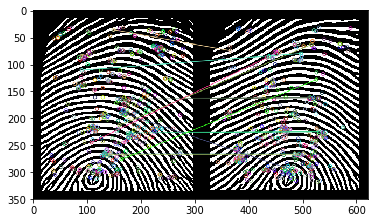

In [25]:
# Example
test_image_id = list(test_set)[3]
authentication_db = authentication_databases['arun']
best_matches_dict = get_best_matches(test_set[test_image_id], authentication_db , 50)
count_same = count_same_fprs(best_matches_dict, 10)
ratio = count_same/len(authentication_db.keys())
print('--- For query image: {} ---'.format(test_image_id))
print('Probability of correct fpr for class arun = {}'.format(round(ratio,4)))
draw_keypoints_matches(test_set[test_image_id], train_set['arun_1.bmp'])

In [26]:
len_best_matches = 15
for dist_threshold in range(30, 70, 10):
    perform_authentication_scenario(dist_threshold, len_best_matches)

----- START, Threshold = 30 -----
Accuracy is 0.500000 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 40 -----
Accuracy is 0.500000 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 50 -----
Accuracy is 0.750000 
The precision score is 1.0
F1 score is 0.6667
----- START, Threshold = 60 -----
Accuracy is 0.500000 
The precision score is 0.5
F1 score is 0.6667


d:\Projects\FingerPrintAnalysis\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\Projects\FingerPrintAnalysis\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
distances, identical = perform_authentication_scenario(50, len_best_matches)
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical)

----- START, Threshold = 50 -----
Accuracy is 0.750000 
The precision score is 1.0
F1 score is 0.6667


In [28]:
stats = get_eer_stats(genuine_scores, impostor_scores)
generate_eer_report([stats], ['A'], 'pyeer_report.csv')

In [29]:
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))

Equal Error Rate is: 0.0


Generating ROC curve: False accept rates vs. false reject rates


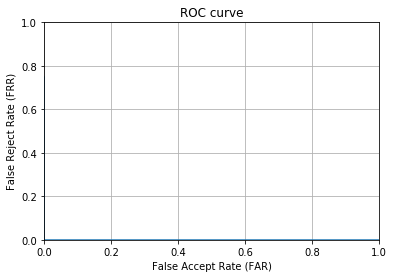

In [30]:
print('Generating ROC curve: False accept rates vs. false reject rates')
get_roc_curve(stats.fnmr, stats.fmr)